# Data Story: Group 6
### Alessandro, Ian, Sungjoon

# Improving Parameterization of Vertical Mixing Coefficients Using an Optimizated Bidirectional LSTM Neural Network


In this project, we attempt to improve on the first Multilayer Perceptron (MLP) neural network used by Sane et al. in the paper "Parameterizing vertical mixing coefficients in the ocean surface boundary layer using neural networks" to predict the shape function of vertical diffusivity in the ocean. We do this by altering the architecture of the neural network and by optimizing the model with different activation functions, batch normalization techniques, node-specific weights, and learning rates.

This notebook provides the data story for our group's improvement of **parameterizing vertical mixing in the ocean surface boundary layer using machine learning techniques.**

### Contents:
- **1. Data Processing and Preparation**
- **2. Problem Identification**
- **3. Neural Network Architecture (Model Selection)**: Implementing LSTM, Bidirectional LSTM, Convolutional NNs
- **4. Training Optimization**: Optimizing activation functions, weights, loss functions
- **5. Model Evaluation and Visualization**: Analyzing the model's skill using metrics like training/validation loss, and visualizing results.
- **6. Conclusion**: Evaluating the results of the investigation
###

# 1. Setup workspace and Import packages, Import Data Sets, Helper Code
Click on arrow to the left to collapse this section for brevity.

In [1]:
%%capture
import importlib

# Check and install torch
if importlib.util.find_spec("torch") is None:
    !pip install torch

# Check and install zarr
if importlib.util.find_spec("zarr") is None:
    !pip install zarr

# Ensure xarray is upgraded
!pip install --upgrade xarray


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import copy as copy
import matplotlib as mpl
import netCDF4 as ncd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from torch import nn, optim
import matplotlib.cm as cm
import copy as copy
import multiprocessing as mp
from scipy import stats
import time as time
import matplotlib.font_manager
import seaborn as sns
import pandas as pd
from tqdm import tqdm  # Import tqdm for the progress bar
import xarray as xr
import requests
import time
from datetime import datetime
import warnings
import warnings
warnings.filterwarnings("ignore")


today = datetime.today()
torch.cuda.empty_cache()

cwd=os.getcwd()
parent_dir = os.path.dirname(cwd)
os.chdir(parent_dir)
cwd = parent_dir
print("Current working directory:", os.getcwd())

# custom modules
import lib.func_file as ff
from lib.visual_figure4 import performance_sigma_point
from lib.visual_figure3 import score_eval, save_losses_by_seed, plot_n1_scores

np.random.seed(100)

cwd_data = cwd + '/data/'
##
cwd_output = cwd + '/output/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Current working directory: /home/jovyan/NO/Project-StarterCodes/Project2-Parameterization


In [3]:
# d=ncd.Dataset(cwd_data+'training_data_raw_time_index_49_149.nc').variables

store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/raw_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

h=d['h'][:]
h_ind1=np.where(h>10)[0]
h_ind2=np.where(h<700)[0]
h_ind=np.intersect1d(h_ind1,h_ind2)
sf1=d['SF'][h_ind,:]
sf1=sf1[237945:237945+5000,:] # randomly selected few profiles.

sf=np.zeros([len(sf1),16])

# for i in range(len(sf1)):
#     sf[i,:]=sf1[i,:]/np.max(sf1[i,:])

sf1 = sf1.values if hasattr(sf1, "values") else sf1
sf = sf1 / np.max(sf1, axis=1, keepdims=True)

sig=np.linspace(0,1,18)
z=np.linspace(0,1,100)
z1=z*(1-z)**2
z1=z1/np.max(z1)

sfmin=np.zeros(18)
sfmax=np.zeros(18)
sfmin[1:17]=np.min(sf,axis=0)
sfmax[1:17]=np.max(sf,axis=0)




In [4]:
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

# d=ncd.Dataset(cwd_data+'training_data_for_SF_hbl_gaps_filled.nc').variables

def corio(lat):
    return  2*(2*np.pi/(24*60*60)) * np.sin(lat*(np.pi/180))

l0=corio(d['l'][:])
b00=d['b0'][:]
ustar0=d['ustar'][:]
h0=d['h'][:]
lat0=d['lat'][:]
heat0=d['heat'][:]
tx0=d['tx'][:]
tx0=np.round(tx0,2)
SF0=d['SF'][:]


In [5]:
ind101=np.where(np.abs(heat0)<601)[0]
ind1=ind101
ind2=np.where(tx0<1.2)[0]
ind3=np.where(h0>29)[0]

ind4=np.where(h0<301)[0]

ind5=np.intersect1d(ind1,ind2)
ind6=np.intersect1d(ind3,ind5)
ind7=np.intersect1d(ind4,ind6)

In [6]:
mm1=0; mm2=16  #0; 16
data_load_main=np.zeros([len(h0[ind7]),4+mm2-mm1])
data_load_main[:,0]=l0[ind7]
data_load_main[:,1]=b00[ind7]
data_load_main[:,2]=ustar0[ind7]
data_load_main[:,3]=h0[ind7]
data_load_main[:,4:(mm2-mm1+4)]=SF0[ind7,mm1:mm2]

data_forc=np.zeros([len(ind7),3])
data_forc[:,0]=lat0[ind7]
data_forc[:,1]=heat0[ind7]
data_forc[:,2]=tx0[ind7]

data_load3=copy.deepcopy(data_load_main)

print('started')

data, x,y, stats, k_mean, k_std=ff.preprocess_train_data(data_load3)


started


In [7]:
# valid_data=np.loadtxt(cwd_data+'data_testing_4_paper.txt')[:,3:]

url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
valid_data = np.loadtxt(url, delimiter=None)[:,3:]

ind3=np.where(valid_data[:,3]>29)[0]
ind4=np.where(valid_data[:,3]<301)[0]
ind=np.intersect1d(ind3,ind4)

valid_x=valid_data[ind,0:4]

valid_x[:,0]=(valid_x[:,0]-stats[0])/stats[1]
valid_x[:,1]=(valid_x[:,1]-stats[2])/stats[3]
valid_x[:,2]=(valid_x[:,2]-stats[4])/stats[5]
valid_x[:,3]=(valid_x[:,3]-stats[6])/stats[7]
k_mean_test=np.zeros(16)
valid_y=valid_data[ind,5:]

for i in range(len(valid_y)):
    valid_y[i,:]=np.log(valid_y[i,:]/np.max(valid_y[i,:]))

for i in range(16):
    valid_y[:,i]=(valid_y[:,i]-k_mean[i])/k_std[i]

In [8]:
x=torch.FloatTensor(x).to(device)
y=torch.FloatTensor(y).to(device)

valid_x=torch.FloatTensor(valid_x).to(device)
valid_y=torch.FloatTensor(valid_y).to(device)

In [9]:
class learnKappa_vanilla(nn.Module):
    def __init__(self, In_nodes, Hid, Out_nodes):
        super(learnKappa_vanilla, self).__init__()
        self.linear1 = nn.Linear(In_nodes, Hid)  # First layer: Input to hidden
        self.linear2 = nn.Linear(Hid, Hid)       # Second layer: Hidden to hidden
        self.linear3 = nn.Linear(Hid, Out_nodes) # Third layer: Hidden to output
        self.dropout = nn.Dropout(0.25)          # Dropout for regularization

    def forward(self, x):
        x2 = self.linear1(x)
        h1 = torch.relu(x2)            # ReLU activation for layer 1
        h1 = self.dropout(h1)          # Apply dropout

        h2 = self.linear2(h1)
        h3 = torch.relu(h2)            # ReLU activation for layer 2
        h3 = self.dropout(h3)          # Apply dropout

        y_pred = self.linear3(h3)      # Final output layer
        return y_pred

def modeltrain_loss(In_nodes, Hid, Out_nodes, lr, epochs, x, y, valid_x, valid_y, model, k_std_y, k_mean, k_std, patience=30):
    optimizer = torch.optim.Adam(model.parameters(), lr)  # Adam optimizer
    loss_fn = torch.nn.L1Loss(reduction='mean')  # L1 loss for gradient computation
    loss_array = torch.zeros([epochs, 3])  # Array to store epoch, train, and validation losses

    best_loss = float('inf')  # Initialize the best validation loss as infinity
    no_improvement = 0  # Counter for epochs without improvement
    best_model_state = None  # Placeholder for the best model state

    # Add a progress bar
    with tqdm(total=epochs, desc="Training Progress", unit="epoch") as pbar:
        for k in range(epochs):
            optimizer.zero_grad()  # Clear gradients from the previous step
            y_pred = model(x)  # Forward pass for training data

            valid_pred = model(valid_x)  # Forward pass for validation data

            # Loss used for gradient calculation
            loss = loss_fn(y_pred * k_std_y, y * k_std_y)

            loss_train = torch.mean(torch.abs(torch.exp(y_pred * k_std + k_mean) - torch.exp(y * k_std + k_mean)))
            loss_valid = torch.mean(torch.abs(torch.exp(valid_pred * k_std + k_mean) - torch.exp(valid_y * k_std + k_mean)))

            loss.backward()  # Backpropagate the gradient
            optimizer.step()  # Update model parameters

            # Record the losses for this epoch
            loss_array[k, 0] = k
            loss_array[k, 1] = loss_train.item()
            loss_array[k, 2] = loss_valid.item()

            # Update the progress bar with the current epoch and losses
            pbar.set_postfix(
                train_loss=loss_train.item(),
                valid_loss=loss_valid.item(),
                patience_count=no_improvement
            )
            pbar.update(1)  # Increment the progress bar

            # Early stopping: Check if validation loss improves
            if loss_valid.item() < best_loss:
                best_loss = loss_valid.item()  # Update best loss
                no_improvement = 0
                best_model_state = model.state_dict()
            else:
                no_improvement += 1  # Increment no improvement counter

            # If no improvement for 'patience' epochs, stop training
            if no_improvement >= patience:
                print(f"\nEarly stopping at epoch {k+1}. Validation loss has not improved for {patience} epochs.")
                break

            # Free memory by deleting intermediate variables
            del loss, y_pred

    # Restore the best model state after training
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, loss_array[:k, :]

def plot_loss(loss_array):
    plt.plot(loss_array[:, 0], loss_array[:, 1], label="Training Loss")
    plt.plot(loss_array[:, 0], loss_array[:, 2], label="Validation Loss")

    # Adding labels and title
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")

    # Adding a legend
    plt.legend()

    # Displaying the plot
    plt.show()

def full_validation(model, valid_x, valid_y, k_std_y, k_mean, k_std):
    model.eval()  # Set model to evaluation mode
    start_time = time.time()

    with torch.no_grad():  # Disable gradient computation
        valid_pred = model(valid_x)  # Forward pass on validation data

        # Compute validation loss in the same way as during training
        loss_valid = torch.mean(torch.abs(torch.exp(valid_pred * k_std + k_mean) - torch.exp(valid_y * k_std + k_mean)))

    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Validation Loss: {loss_valid.item():.6f}")
    print(f"Validation Time: {elapsed_time:.4f} seconds")

    return loss_valid.item(), elapsed_time

def unscale_and_exp(arr, k_mean, k_std):
    arr = arr * k_std + k_mean
    arr = np.exp(arr)
    return arr
def visualize_examples(model, valid_x, valid_y):
    model.eval()
    if isinstance(valid_x, np.ndarray):
        valid_x_tensor = torch.from_numpy(valid_x).float()
    else:
        valid_x_tensor = valid_x.clone().detach().float()
    device = next(model.parameters()).device
    valid_x_tensor = valid_x_tensor.to(device)
    with torch.no_grad():
        valid_pred = model(valid_x_tensor).cpu().numpy()
    true_vals = unscale_and_exp(valid_y.cpu().numpy(), k_mean, k_std)
    pred_vals = unscale_and_exp(valid_pred, k_mean, k_std)
    # Pick 10 arbitrary samples to visualize
    indices = [24635, 12102, 63217, 64187, 18303, 55554, 11640, 36692, 34786, 77025]
    n_samples = len(indices)

    # Create 5x2 subplots
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 15))
    axes = axes.flatten()  # Flatten to easily iterate over them
    for i, idx in enumerate(indices):
        ax = axes[i]
        ax.plot(range(1, 17), true_vals[idx], label='True', marker='o')
        ax.plot(range(1, 17), pred_vals[idx], label='Predicted', marker='x')
        ax.set_title(f'Sample {idx}')
        ax.set_xlabel('Output Node Index (1-16)')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid(True)
    plt.tight_layout()
    plt.show()

# 2. Problem Identification

## 2.1 Train original model (2 Hidden Layers, 32 Nodes each)

First, we need to establish a baseline for comapring changing in model architecture and optimization. To do that, let's train the original "vanilla" model used in Sane et al. (2023).

In [10]:
epochs, k_points, lr=3000, 16, 1e-03
in_nod, hid_nod, o_nod = 4, 32, 16
kmask=np.array([1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])

torch.manual_seed(10)

k_mean_c=torch.tensor(k_mean).float().to(device)
k_std_c=torch.tensor(k_std).float().to(device)

model = learnKappa_vanilla(in_nod, hid_nod, o_nod)
model = model.to(device)
model, loss_array = modeltrain_loss(in_nod, hid_nod, o_nod, lr, epochs, x, y,valid_x,valid_y,model,torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)
val_loss, val_time = full_validation(model, valid_x, valid_y, torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)

Training Progress:  32%|███▏      | 947/3000 [00:31<01:08, 29.88epoch/s, patience_count=29, train_loss=0.0379, valid_loss=0.055] 



Early stopping at epoch 947. Validation loss has not improved for 30 epochs.
Validation Loss: 0.047763
Validation Time: 0.0003 seconds


## 2.2 Establish Evaluation Criteria

When assessing how Sane et al.'s vanilla model performs, there are a few different metrics that we can use.
### Key Evaluation Metrics include:
- **Computational complexity of Neural Network at Runtime**:
    - **Neural Network Training Time**: Training should be completed within a reasonable time
    - **Validation Error Rate**: Low validation error means better generalization on unseen examples
- **Practical Results**:
    - **Error Distribution Curve**
    - **Observations and Predictions**

We want to minimize the training time so that the model can be implemented within larger Earth System Models, we want to have low validation error so that the model can predict the vertical diffusivity shape function when given a diverse range of input features, and practically we want to minimize the error around each output node. Finally, we can assess model predictions as a whole by plotting both the observations and predictions together, in this case the shape function of vertical diffusivity predicted by the General Ocean Turbulence Model and the shape function predicted by the neural network. We want the predictions to be as close to the observations as possible.

Let's have a look at some of these evaluation metrics for the vanilla model originally used by Sane et al.:

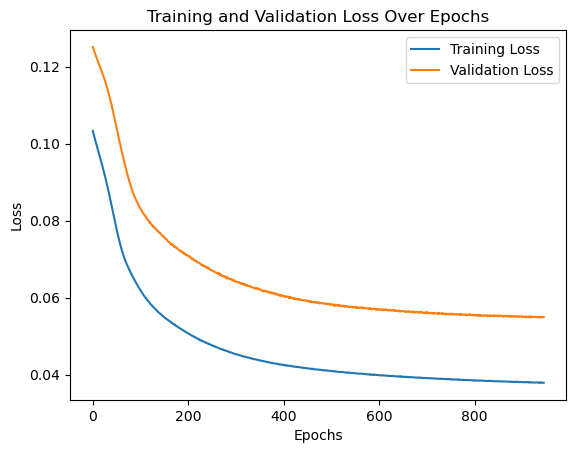

In [11]:
plot_loss(loss_array)

Plot saved as 'modelstats.pdf'


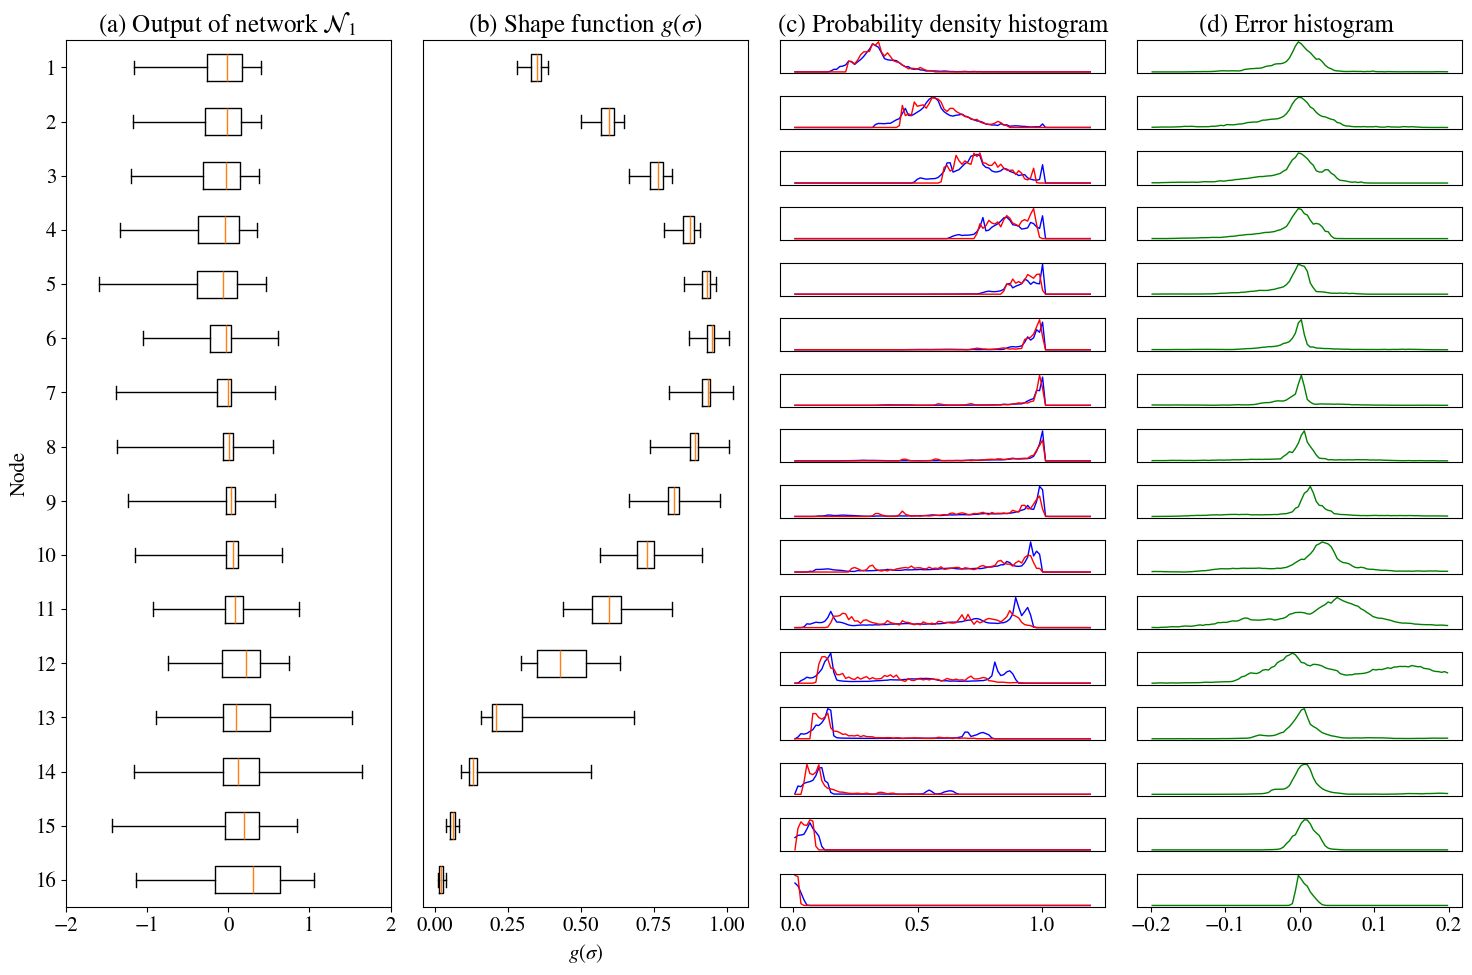

In [12]:
performance_sigma_point(model, x, valid_x, y, valid_y, k_mean, k_std)

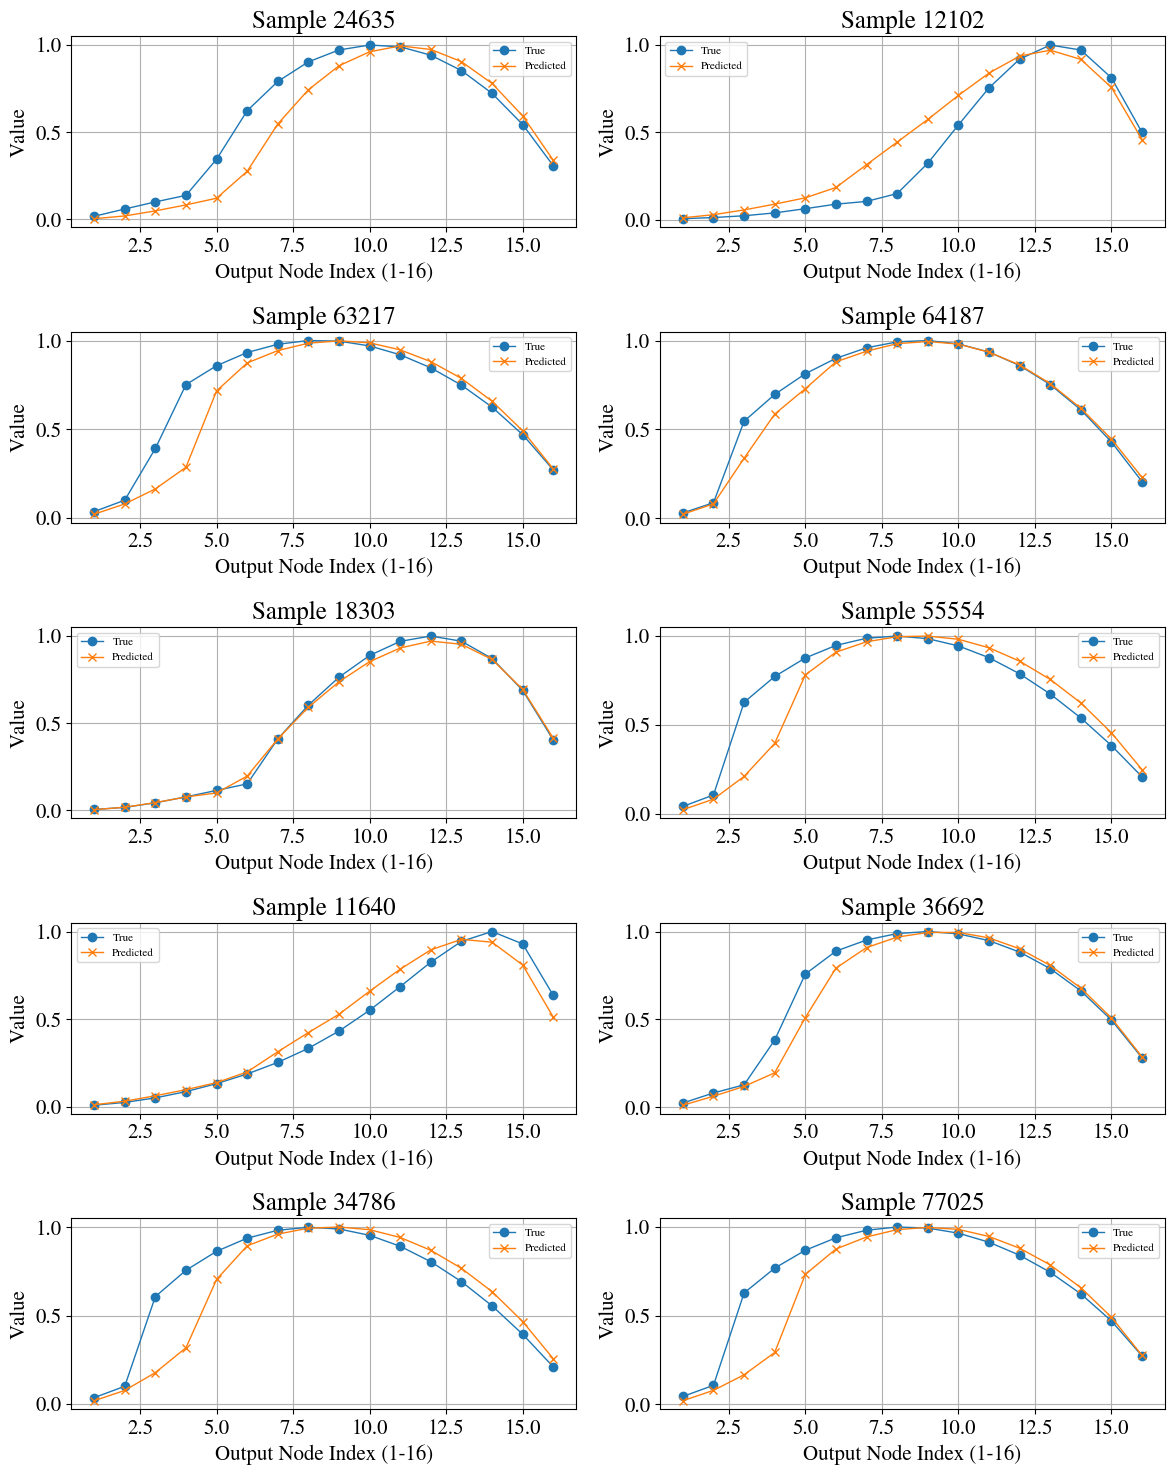

In [13]:
visualize_examples(model, valid_x, valid_y)
del model, loss_array

In [14]:
import gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
torch.cuda.empty_cache()

## 2.3 Several things to notice:

1. The model fails to capture the bimodal distribution on ouptut nodes 11-14 in panel (d) of the second figure above.
2. The model is extremely efficient, completing the full validation in 0.0004 seconds
3. Full validation loss of 0.04830, which means model’s predicted values differ from the true values by about 4.83% of the original value range
4. Unstable , often wide error histogram meaning many predictions are quite far off from the true label, which we can see in the plots of observed and predicted shape functions

## 2.4 Project Directions:
Sane et al.’s “vanilla” MLP model is quite limited in its expressive power when it comes to certain output nodes of the shape function.

We target the bimodal distribution in the probability density histograms of particular nodes (nodes 11-14), where the vertical diffusivity could be either very high or very low.

This bimodal distribution results in a very wide error histogram for the "vanilla" MLP model with 2 hidden layers, indicating poor performance for these output nodes.

If we can better predict the values of the shape function at these bimodal nodes, we should be able to drastically improve model performance and the prediction of the overall shape function.

Thus, this project seeks to improve the prediction of the bimodal output nodes (nodes 11-14), and with that of the shape function overall, by modifying the neural network architecture and implementing certain optimization techniques to improve upon the model developed by Sane et al. (2023).

# 3. Neural Network Architecture (Model Selection)

The first way we will attempt to improve upon the vanilla model is by changing the neural network model architecture. We are going to evaluate four new architetures, and the best performing architecture will be used as the base for our final model.

## 3.1 Add a Fully Connected Layer (3 Hidden Layers Total)
The simplest, most straightforward change to the model’s architecture that we can make is by just adding another hidden layer. Because we’re simply increasing the complexity of the vanilla model, this new architecture almost by definition should improve the model’s performance. However, we need to assess if the improvements made by adding another layer is worth the additional computational cost of added model complexity.

In [15]:
class learnKappa_layers(nn.Module):
    def __init__(self, In_nodes, Hid, Out_nodes):
        super(learnKappa_layers, self).__init__()

        self.linear1 = nn.Linear(In_nodes, Hid)   # Input to Hidden 1
        self.linear2 = nn.Linear(Hid, Hid)        # Hidden 1 to Hidden 2
        self.linear3 = nn.Linear(Hid, Hid)        # Hidden 2 to Hidden 3
        self.linear4 = nn.Linear(Hid, Out_nodes)  # Hidden 3 to Output
        self.dropout = nn.Dropout(0.25)           # Dropout Regularization

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)           # Apply Activation
        #x = self.dropout(x)         # Apply Dropout

        x = self.linear2(x)
        x = torch.relu(x)           # Apply Activation
        x = self.dropout(x)         # Apply Dropout

        x = self.linear3(x)
        x = torch.relu(x)           # Apply Activation

        y_pred = self.linear4(x)    # Final Output
        return y_pred


## 3.2 LSTM

One very common type of neural network architecture that we could implement is a Long Short-Term Memory (LSTM) neural network. LSTMs are a type of recurrent neural network (RNN) which capture long term dependencies, or trends, in sequentially ordered data. Since our data is spatially correlated (i.e. nearby points likely have more similar vertical diffusivity compared to points in a completely different ocean), this type of model structure might help us capture some of those spatial trends when training the model.

In [16]:
class learnKappa_LSTM(nn.Module):
    def __init__(self, In_nodes, Hid, Out_nodes):
        super(learnKappa_LSTM, self).__init__()

        self.linear1 = nn.Linear(In_nodes, Hid)   # Input to Hidden 1
        self.linear2 = nn.Linear(Hid, Hid)        # Hidden 1 to Hidden 2
        self.linear3 = nn.Linear(Hid, Hid)        # Hidden 2 to Hidden 3

        self.lstm = nn.LSTM(Hid, Hid, batch_first=True)

        self.linear4 = nn.Linear(Hid, Out_nodes)  # LSTM Output to Final Output
        self.dropout = nn.Dropout(0.25)           # Dropout Regularization

    def forward(self, x):
        # 1) First three linear layers + ReLU + Dropout
        x = self.linear1(x)
        x = torch.relu(x)

        x = self.linear2(x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        x = torch.relu(x)

        # 2) Reshape for LSTM: (batch_size, seq_len=1, Hid)
        x = x.unsqueeze(1)

        # 3) LSTM forward pass
        x, _ = self.lstm(x)

        # 4) Remove sequence dimension => (batch_size, Hid)
        x = x.squeeze(1)
        x = torch.relu(x)

        # 6) Final projection
        y_pred = self.linear4(x)
        return y_pred

## 3.3 Bidirectional LSTM

We can also try implementing a bidirectional LSTM, which is similar to the LSTM implemented above, but it processes the data sequentially in two directions (i.e. forward AND backwards) instead of just one directions, as used in the original LSTM (i.e. forward). Processing data in both directions allows the model to pick up on trends in the data that exist both after and before the current prediction, so the bidirectional LSTM might capture even more spatial correlation.

In [17]:
class learnKappa_LSTM_bidirectional(nn.Module):
    def __init__(self, In_nodes, Hid, Out_nodes, bidirectional=True):
        super(learnKappa_LSTM_bidirectional, self).__init__()  # Use the correct class name here

        self.linear1 = nn.Linear(In_nodes, Hid)   # Input to Hidden 1
        self.linear2 = nn.Linear(Hid, Hid)        # Hidden 1 to Hidden 2
        self.linear3 = nn.Linear(Hid, Hid)        # Hidden 2 to Hidden 3

        self.lstm = nn.LSTM(Hid, Hid, batch_first=True, bidirectional=bidirectional)
        self.linear4 = nn.Linear(Hid * 2 if bidirectional else Hid, Out_nodes)

        self.dropout = nn.Dropout(0.25)           # Dropout Regularization

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)

        x = self.linear2(x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.linear3(x)
        x = torch.relu(x)

        # Reshape for LSTM input: (batch_size, seq_len=16, features=Hid)
        x = x.unsqueeze(1)  # Add sequence dimension

        # LSTM processes sequence (Bidirectional if True)
        x, _ = self.lstm(x)

        # Take the last output time step (seq_len=-1)
        x = x[:, -1, :]  # Shape: [batch_size, Hid * 2] if bidirectional

        y_pred = self.linear4(x)  # Final Output
        return y_pred

## 3.4 Two Fully Connected Layers + Two Convolutional Layers

Finally, we will also change the architecture by adding in two convolutional layers, instead of adding more fully connected layers. In convolutional layers, not all input nodes affect all output nodes, which might let us hone in on a model that is able to capture the trends in shape functions that we want to predict.

In [18]:
class learnKappa_reverseConv(nn.Module):
    def __init__(self, in_features=4, hidden_dim=32, out_features=16):
        super(learnKappa_reverseConv, self).__init__()

        self.fc1 = nn.Linear(in_features, hidden_dim)    # Input to Hidden 1
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)     # Hidden 1 to Hidden 2


        self.hidden_side = int(hidden_dim ** 0.5)  # sqrt of hidden_dim
        self.hidden_dim_adjusted = self.hidden_side ** 2
        if hidden_dim != self.hidden_dim_adjusted:
            self.fc_adjust = nn.Linear(hidden_dim, self.hidden_dim_adjusted)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)

        # Final fully connected layer to output
        self.final_conv_size = 16 * self.hidden_side * self.hidden_side
        self.fc3 = nn.Linear(self.final_conv_size, out_features)

        # Regularization
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        batch_size = x.size(0)

        # Apply fully connected layers first
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = torch.relu(x)
        x = self.dropout(x)

        if hasattr(self, 'fc_adjust'):
            x = self.fc_adjust(x)
            x = torch.relu(x)

        x = x.view(batch_size, 1, self.hidden_side, self.hidden_side)
        x = self.conv1(x)
        x = torch.relu(x)

        x = self.conv2(x)
        x = torch.relu(x)
        x = x.view(batch_size, -1)
        x = self.fc3(x)

        return x

Now, let's train and validate those four new model architectures!

In [19]:
epochs = 3000
k_points = 16
lr = 1e-3
in_nod, hid_nod, o_nod = 4, 32, 16


kmask=np.array([1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])
torch.manual_seed(10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
k_mean_c = torch.tensor(k_mean).float().to(device)
k_std_c  = torch.tensor(k_std).float().to(device)


model_classes = [
    ("MLP_3_Layers", learnKappa_layers),
    ("LSTM", learnKappa_LSTM),
    ("LSTM_Bidirectional", learnKappa_LSTM_bidirectional),
    ("ConvLayer", learnKappa_reverseConv)
]

# Dictionary to store results
results = {}

for model_name, ModelClass in model_classes:
    print(f"\n==== Training Model: {model_name} ====")

    if model_name == "LSTM_Bidirectional":
        model = ModelClass(in_nod, hid_nod, o_nod, bidirectional=True)
    else:
        model = ModelClass(in_nod, hid_nod, o_nod)

    model = model.to(device)

    model, loss_array = modeltrain_loss(in_nod, hid_nod, o_nod, lr, epochs, x, y,valid_x,valid_y,model,torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)
    val_loss, val_time = full_validation(model, valid_x, valid_y, torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)

    results[model_name] = {
        "model": model,
        "loss_array": loss_array,
        "val_loss": val_loss,
        "val_time" : val_time
    }
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.ipc_collect()
del model, loss_array



==== Training Model: MLP_3_Layers ====


Training Progress:  50%|█████     | 1506/3000 [00:59<00:58, 25.43epoch/s, patience_count=29, train_loss=0.0209, valid_loss=0.0331]



Early stopping at epoch 1506. Validation loss has not improved for 30 epochs.
Validation Loss: 0.030696
Validation Time: 0.0007 seconds

==== Training Model: LSTM ====


Training Progress:  22%|██▏       | 670/3000 [02:32<08:51,  4.38epoch/s, patience_count=29, train_loss=0.0238, valid_loss=0.0356]



Early stopping at epoch 670. Validation loss has not improved for 30 epochs.
Validation Loss: 0.033675
Validation Time: 0.0021 seconds

==== Training Model: LSTM_Bidirectional ====


Training Progress:  26%|██▌       | 769/3000 [05:21<15:33,  2.39epoch/s, patience_count=29, train_loss=0.0206, valid_loss=0.0321]



Early stopping at epoch 769. Validation loss has not improved for 30 epochs.
Validation Loss: 0.028999
Validation Time: 0.0021 seconds

==== Training Model: ConvLayer ====


Training Progress:  33%|███▎      | 998/3000 [09:46<19:36,  1.70epoch/s, patience_count=29, train_loss=0.0233, valid_loss=0.0387]



Early stopping at epoch 998. Validation loss has not improved for 30 epochs.
Validation Loss: 0.034817
Validation Time: 0.0009 seconds


As expected, the MLP model with more layers does perform better than the vanilla model, but not by a whole lot. I think we can do better if we make some bigger changes to the model’s architecture.

The LSTM may not have performed that well because the shape functions are not necessarily predicted by the neural network in a spatially correlated order, meaning that information on the previous shape function may not actually improve model performance since the previous shape function is not that similar to the shape function being predicted. The bidirectional LSTM avoids this by **“casting a bigger net”** and using information on the previous and the next prediction (shape function) when predicting the current shape function.  

The Bidirectional LSTM performed the best, but took a lot longer to train and almost 3x the amount of time to validate compared to the model with 3 fully-connected hidden layers!
If we’re hoping to implement a new, improved final model into an Earth System Model to predict shape functions around the world, the computational cost of the Bidirectional LSTM may be too high, so it could be a drawback to selecting this model. Since we don't have ay plans to implement this model, however, we will go ahead with this model because the validation time is still under 0.01 seconds.

# 4. Model Training Optimizations

Now that we’ve established that the Bidirectional LSTM appears to be the best model choice, and it makes significant improvements compared to the vanilla model used by Sane et al. (2023), we can continue improving the shape function predictions by sequentially modifying different aspects of the Bidirectional LSTM model’s architecture.

## 4.1 Tanh Activation Function

One of the simplest ways that we can modify the LSTM-Bi model’s architecture is by changing the activation function used in the hidden layer. In the vanilla model, we used the standard ReLU function, which is useful for hidden layers and for learning complexity. Another activation function, tanh, is more commonly used in RNNs like LSTM-Bi, however, so it might be a better choice for our new model going forward. Let’s implement a tanh activation function:

In [20]:
class learnKappa_LSTM_bidirectional_tanh(nn.Module):
    def __init__(self, In_nodes, Hid, Out_nodes, bidirectional=True):
        super(learnKappa_LSTM_bidirectional_tanh, self).__init__()  # Use the correct class name here

        self.linear1 = nn.Linear(In_nodes, Hid)   # Input to Hidden 1
        self.linear2 = nn.Linear(Hid, Hid)        # Hidden 1 to Hidden 2
        self.linear3 = nn.Linear(Hid, Hid)        # Hidden 2 to Hidden 3

        self.lstm = nn.LSTM(Hid, Hid, batch_first=True, bidirectional=bidirectional)
        self.linear4 = nn.Linear(Hid * 2 if bidirectional else Hid, Out_nodes)

        self.dropout = nn.Dropout(0.25)           # Dropout Regularization

    def forward(self, x):
        x = self.linear1(x)
        x = torch.tanh(x)

        x = self.linear2(x)
        x = torch.tanh(x)
        x = self.dropout(x)

        x = self.linear3(x)
        x = torch.tanh(x)

        # Reshape for LSTM input: (batch_size, seq_len=16, features=Hid)
        x = x.unsqueeze(1)  # Add sequence dimension

        # LSTM processes sequence (Bidirectional if True)
        x, _ = self.lstm(x)

        # Take the last output time step (seq_len=-1)
        x = x[:, -1, :]  # Shape: [batch_size, Hid * 2] if bidirectional

        y_pred = self.linear4(x)  # Final Output
        return y_pred

epochs, k_points, lr=3000, 16, 1e-03
in_nod, hid_nod, o_nod = 4, 32, 16
kmask=np.array([1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])

torch.manual_seed(10)

k_mean_c=torch.tensor(k_mean).float().to(device)
k_std_c=torch.tensor(k_std).float().to(device)

model = learnKappa_LSTM_bidirectional_tanh(in_nod, hid_nod, o_nod)
model = model.to(device)
model, loss_array = modeltrain_loss(in_nod, hid_nod, o_nod, lr, epochs, x, y,valid_x,valid_y,model,torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)
val_loss, val_time = full_validation(model, valid_x, valid_y, torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)
torch.cuda.empty_cache()

Training Progress:  26%|██▌       | 777/3000 [05:25<15:31,  2.39epoch/s, patience_count=29, train_loss=0.0198, valid_loss=0.0309]


Early stopping at epoch 777. Validation loss has not improved for 30 epochs.
Validation Loss: 0.028716
Validation Time: 0.0020 seconds


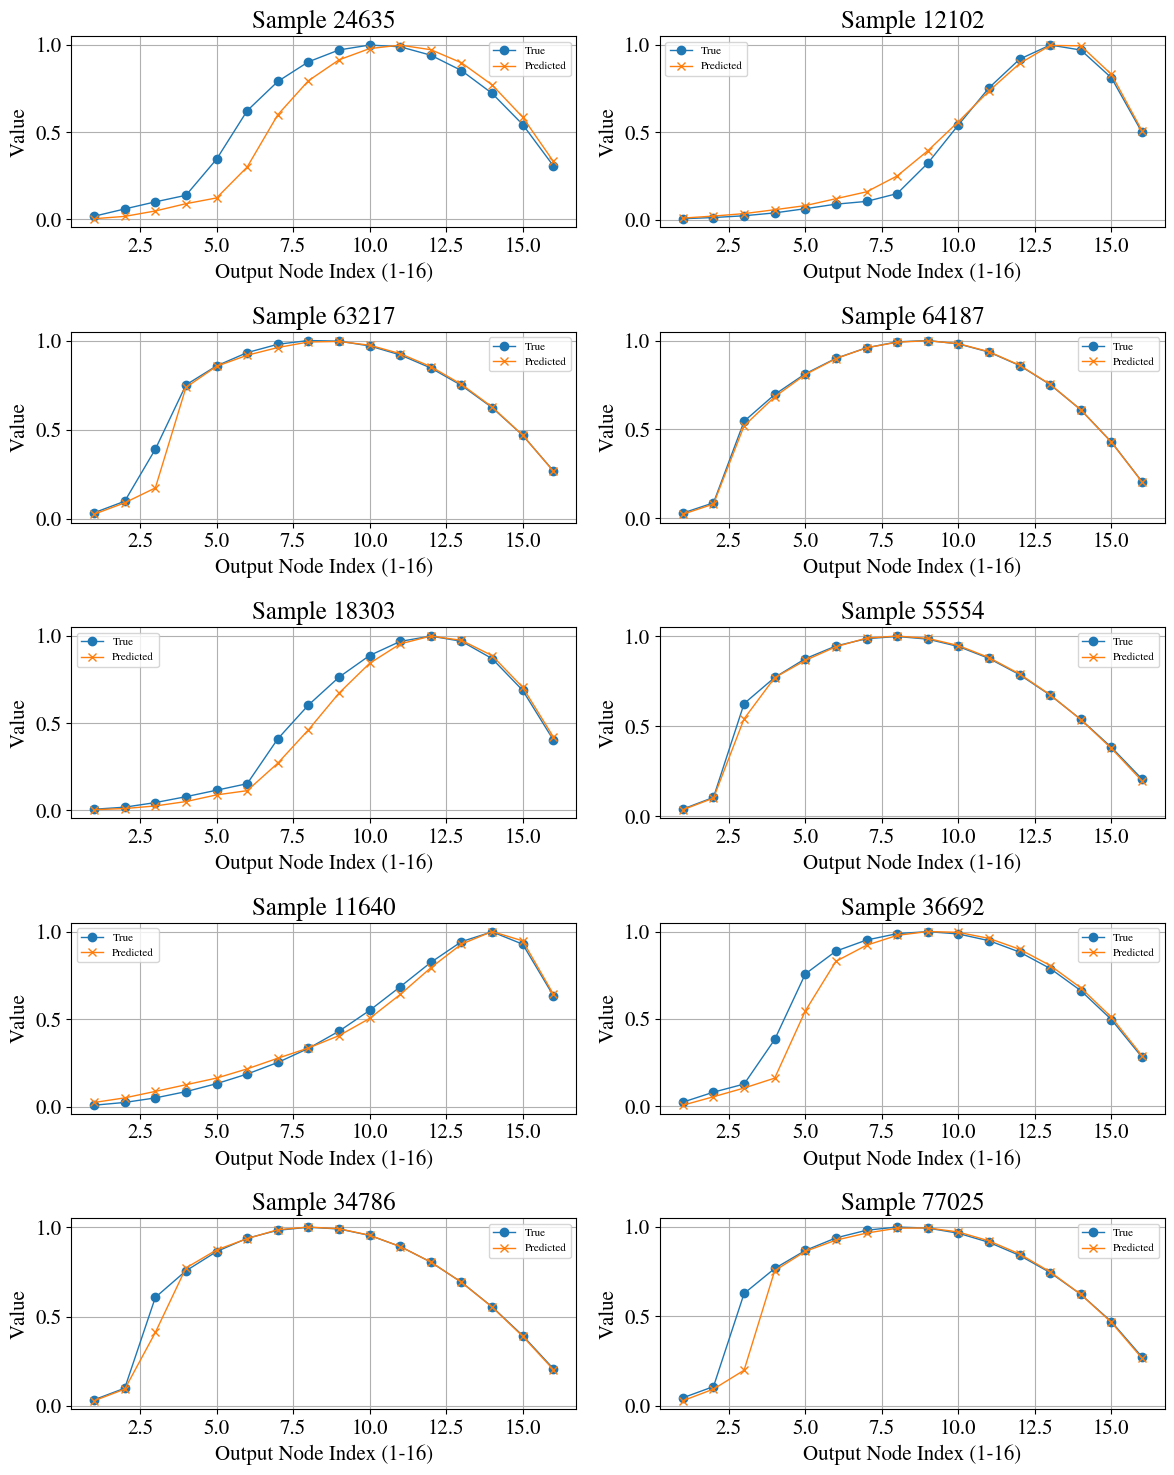

In [21]:
visualize_examples(model, valid_x, valid_y)
del model, loss_array

That looks like it improved the validation loss a little bit! It’s hard to see much change in the shape functions themselves. We’ll keep this in mind as one way to improve model performance that we should include in our final model.

## 4.2 Adaptive Node-Specific Weighting

In the project 2 starter code, we began the process of implementing node-specific weighting, which adjusts the training process by modifying the loss function to prioritize nodes with higher variance. In the vanilla model, we saw that the bimodal output nodes (nodes 11-14) were those which had the highest error, so improving this process to weight nodes 11-14 would be a great way of targeting this project’s goal of improving the model’s prediction of the bimodal output nodes. We can improve node-specific weighting by applying adaptive node-specific weighting.

Here, we develop node-specific weights is by running two Bidirectional LSTM models in series, and using the node-specific error of the first model to inform the weights used in the second model. The second model would then be used to predict the final shape function. Let’s implement that:


In [22]:
# Set the seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Hyperparameters
epochs, k_points, lr = 3000, 32, 1e-03

# Initial weights (kms) – all the same
initial_weight = 50.0
kms = np.full(16, initial_weight)  # 16 weights, all initialized to the same value

# Define model parameters
in_nod, hid_nod, o_nod = 4, 32, 16
torch.manual_seed(10)

# Create the mask for weights
kmask = torch.tensor(kms).float().to(device)

# Initialize the model
model = learnKappa_LSTM_bidirectional_tanh(in_nod, hid_nod, o_nod)
model = model.to(device)

# Train the model using the initial kms (weights)
model, loss_array = modeltrain_loss(in_nod, hid_nod, o_nod, lr, epochs, x, y, valid_x, valid_y, model, kmask, k_mean_c, k_std_c)

# Calculate the error of the model
# Assuming model outputs are the final layer's outputs (predictions)
outputs = model(valid_x)
error = torch.abs(outputs - valid_y)  # Calculate absolute error for each output

# Calculate proportional weights based on the error (higher error -> higher weight)
error_mean = torch.mean(error, dim=0)  # Mean error per output node
normalized_error = error_mean / torch.sum(error_mean)  # Normalize the errors

val_loss, val_time = full_validation(model, valid_x, valid_y, torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)

# Update the weights (kms) for the second model
updated_kms = (normalized_error*100) ** 2  # Scale the weights by some factor (e.g., 500)
updated_kms_cpu = updated_kms.detach().cpu().numpy()  # Detach from graph and move to CPU

print("New weights:")
for i, weight in enumerate(reversed(updated_kms_cpu)):
    print(f"Node {len(updated_kms_cpu) - i}: {weight:.4f},")

# Ensure the updated_kms is a tensor
updated_kmask = torch.tensor(updated_kms).float().to(device)

# Train the second model with the updated kms (weights)
model = learnKappa_LSTM_bidirectional_tanh(in_nod, hid_nod, o_nod)
model = model.to(device)
model, loss_array = modeltrain_loss(in_nod, hid_nod, o_nod, lr, epochs, x, y, valid_x, valid_y, model, updated_kmask, k_mean_c, k_std_c)
val_loss, val_time = full_validation(model, valid_x, valid_y, torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)


Training Progress:  28%|██▊       | 842/3000 [05:52<15:04,  2.39epoch/s, patience_count=29, train_loss=0.0195, valid_loss=0.0305]



Early stopping at epoch 842. Validation loss has not improved for 30 epochs.
Validation Loss: 0.028201
Validation Time: 0.0018 seconds
New weights:
Node 16: 21.0442,
Node 15: 19.1970,
Node 14: 19.2348,
Node 13: 24.7562,
Node 12: 38.6288,
Node 11: 25.2861,
Node 10: 21.4048,
Node 9: 25.0589,
Node 8: 29.7526,
Node 7: 31.1506,
Node 6: 35.4190,
Node 5: 43.1341,
Node 4: 50.4901,
Node 3: 66.6799,
Node 2: 85.6067,
Node 1: 161.6708,


Training Progress:  30%|███       | 903/3000 [06:18<14:39,  2.39epoch/s, patience_count=29, train_loss=0.0194, valid_loss=0.0305]


Early stopping at epoch 903. Validation loss has not improved for 30 epochs.
Validation Loss: 0.028360
Validation Time: 0.0021 seconds


That seems to reduce the validation loss even further! Let's take these weights and apply them for calculations here on out.

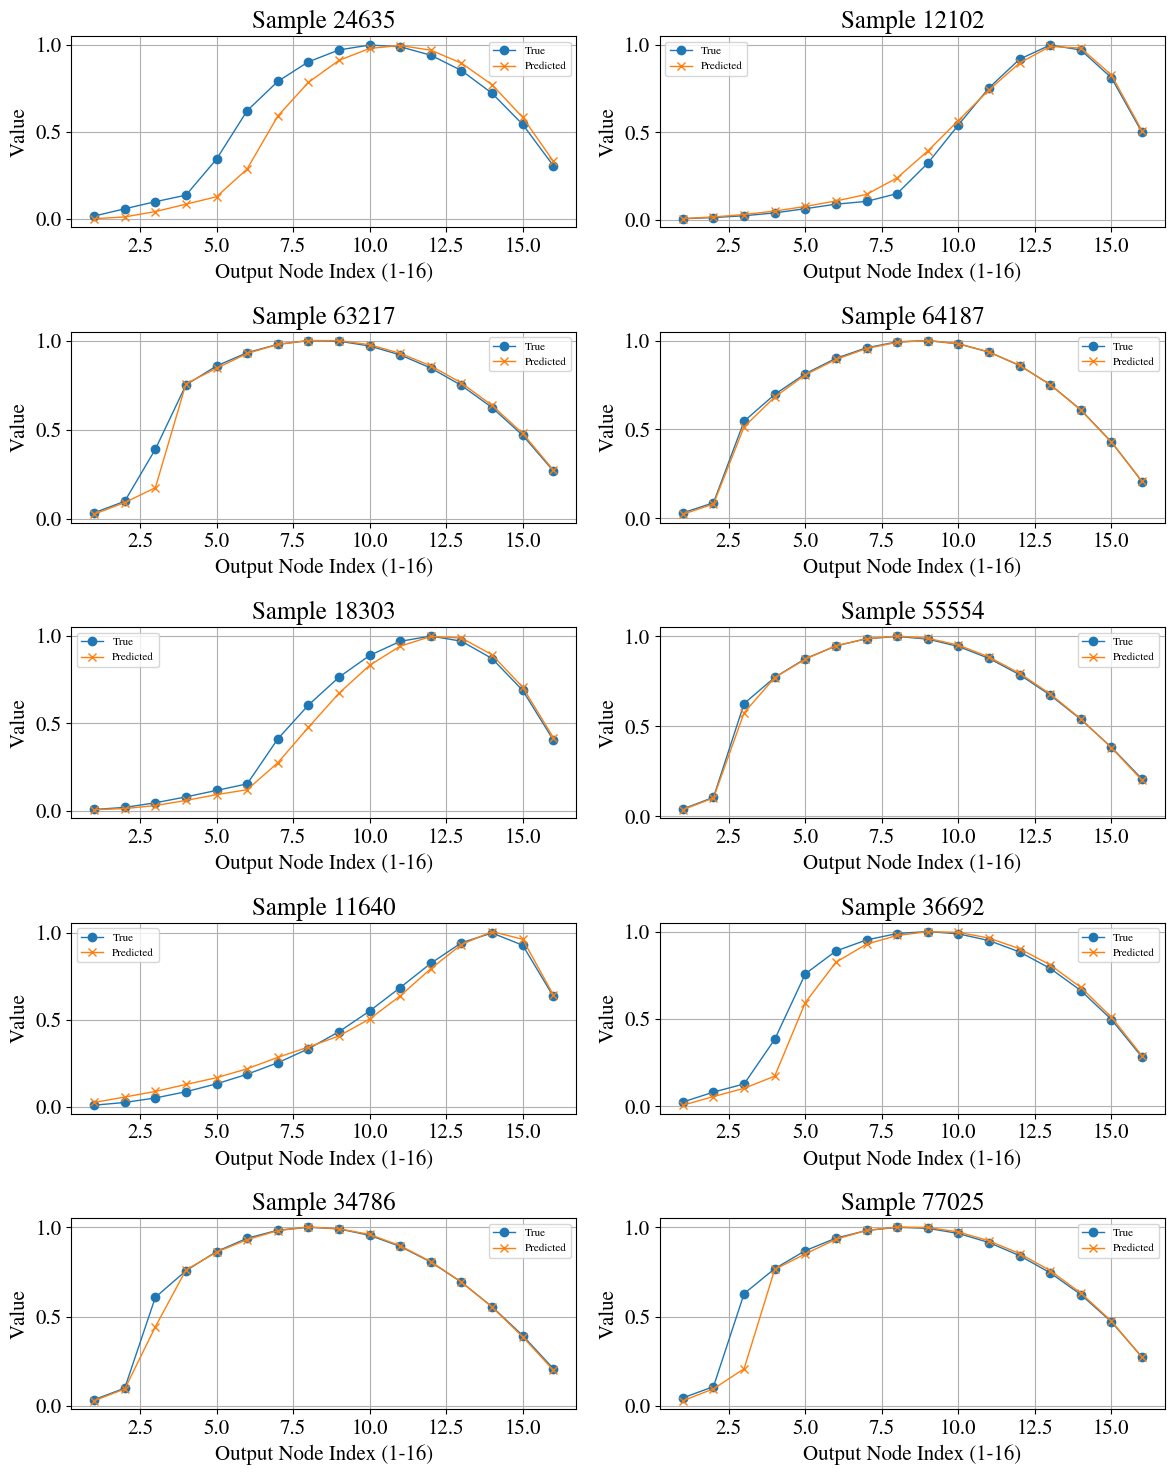

In [23]:
visualize_examples(model, valid_x, valid_y)
del model, loss_array

# 4.3 Modify Loss Function
We can further optimize the model by modifying the loss function that is used to validate the model.

## 4.3.1. Add Weight Decay
Weight decay is a technique that can help prevent our model from overfitting by penalizing large weights during training. It adds a penalty to the loss function which corresponds to the magnitude of weights used in the model, encouraging the model to use smaller weights. This encourages the model to learn simpler, more generalized representations rather than "memorizing" the training data.

In [24]:
def modeltrain_loss_decay(In_nodes, Hid, Out_nodes, lr, epochs, x, y, valid_x, valid_y, model, k_std_y, k_mean, k_std, patience=30):
    optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-5)  # Adam optimizer with weight decay
    loss_fn = torch.nn.L1Loss(reduction='mean')  # L1 loss for gradient computation
    loss_array = torch.zeros([epochs, 3])  # Array to store epoch, train, and validation losses

    best_loss = float('inf')  # Initialize the best validation loss as infinity
    no_improvement = 0  # Counter for epochs without improvement
    best_model_state = None  # Placeholder for the best model state

    # Add a progress bar
    with tqdm(total=epochs, desc="Training Progress", unit="epoch") as pbar:
        for k in range(epochs):
            optimizer.zero_grad()  # Clear gradients from the previous step
            y_pred = model(x)  # Forward pass for training data

            valid_pred = model(valid_x)  # Forward pass for validation data

            # Loss used for gradient calculation
            loss = loss_fn(y_pred * k_std_y, y * k_std_y)

            loss_train = torch.mean(torch.abs(torch.exp(y_pred * k_std + k_mean) - torch.exp(y * k_std + k_mean)))
            loss_valid = torch.mean(torch.abs(torch.exp(valid_pred * k_std + k_mean) - torch.exp(valid_y * k_std + k_mean)))

            loss.backward()  # Backpropagate the gradient
            optimizer.step()  # Update model parameters

            # Record the losses for this epoch
            loss_array[k, 0] = k
            loss_array[k, 1] = loss_train.item()
            loss_array[k, 2] = loss_valid.item()

            # Update the progress bar with the current epoch and losses
            pbar.set_postfix(
                train_loss=loss_train.item(),
                valid_loss=loss_valid.item(),
                patience_count=no_improvement
            )
            pbar.update(1)  # Increment the progress bar

            # Early stopping: Check if validation loss improves, we stop
            if loss_valid.item() < best_loss:
                best_loss = loss_valid.item()  # Update best loss
                no_improvement = 0
                best_model_state = model.state_dict()
            else:
                no_improvement += 1  # Increment no improvement counter

            # If no improvement for 'patience' epochs, stop training
            if no_improvement >= patience:
                print(f"\nEarly stopping at epoch {k+1}. Validation loss has not improved for {patience} epochs.")
                break

            # Free memory by deleting intermediate variables
            del loss, y_pred

    # Restore the best model state after training
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, loss_array[:k, :]

In [25]:
model = learnKappa_LSTM_bidirectional_tanh(in_nod, hid_nod, o_nod)  # Initialize a fresh model
model = model.to(device)
model, loss_array = modeltrain_loss_decay(in_nod, hid_nod, o_nod, lr, epochs, x, y, valid_x, valid_y, model, updated_kmask, k_mean_c, k_std_c)
val_loss, val_time = full_validation(model, valid_x, valid_y, torch.tensor(updated_kmask).float().to(device), k_mean_c, k_std_c)
#visualize_examples(model, valid_x, valid_y)

Training Progress:  39%|███▊      | 1159/3000 [08:05<12:51,  2.39epoch/s, patience_count=29, train_loss=0.019, valid_loss=0.0301] 


Early stopping at epoch 1159. Validation loss has not improved for 30 epochs.
Validation Loss: 0.027640
Validation Time: 0.0031 seconds


## 4.3.2. Add Total variaton loss for smoothness

Adding total variation loss is another modification that we can made to the loss function. This technique smooths over high-frequency noise and encourages smooth predictions. Since oru shape function is a smooth function with no noise, implementing this could be worthwhile.

In [26]:
def total_variation_loss(output):
    """Computes the total variation loss for depth-wise smoothness."""
    return torch.mean((output[:, 1:] - output[:, :-1])**2)  # Enforces smooth depth transitions

def modeltrain_tvloss(In_nodes, Hid, Out_nodes, lr, epochs, x, y, valid_x, valid_y, model,
                    k_std_y, k_mean, k_std, patience=30, tv_weight=0.1):
    """
    Train the neural network model with an additional Total Variation loss term.

    Args:
        tv_weight (float): Regularization weight for the TV loss.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr,weight_decay=1e-5)  # Adam optimizer and weight decay
    loss_fn = torch.nn.L1Loss(reduction='mean')  # L1 loss for gradient computation
    loss_array = torch.zeros([epochs, 3])  # Array to store epoch, train, and validation losses

    best_loss = float('inf')  # Initialize the best validation loss as infinity
    no_improvement = 0  # Counter for epochs without improvement
    best_model_state = None  # Placeholder for the best model state

    # Add a progress bar
    with tqdm(total=epochs, desc="Training Progress", unit="epoch") as pbar:
        for k in range(epochs):
            optimizer.zero_grad()  # Clear gradients from the previous step
            y_pred = model(x)  # Forward pass for training data
            valid_pred = model(valid_x)  # Forward pass for validation data

            # Loss used for gradient calculation (L1 Loss)
            loss = loss_fn(y_pred * k_std_y, y * k_std_y)

            # Compute Total Variation Loss for smoothness
            tv_loss = total_variation_loss(y_pred)

            # Combine standard loss with TV loss
            total_loss = loss + tv_weight * tv_loss

            loss_train = torch.mean(torch.abs(torch.exp(y_pred * k_std + k_mean) - torch.exp(y * k_std + k_mean)))
            loss_valid = torch.mean(torch.abs(torch.exp(valid_pred * k_std + k_mean) - torch.exp(valid_y * k_std + k_mean)))

            total_loss.backward()  # Backpropagate the gradient
            optimizer.step()  # Update model parameters

            # Record the losses for this epoch
            loss_array[k, 0] = k
            loss_array[k, 1] = loss_train.item()
            loss_array[k, 2] = loss_valid.item()

            # Update the progress bar with the current epoch and losses
            pbar.set_postfix(
                train_loss=loss_train.item(),
                valid_loss=loss_valid.item(),
                tv_loss=tv_loss.item(),
                patience_count=no_improvement
            )
            pbar.update(1)  # Increment the progress bar

            # Early stopping: Check if validation loss improves
            if loss_valid.item() < best_loss:
                best_loss = loss_valid.item()  # Update best loss
                no_improvement = 0
                best_model_state = model.state_dict()
            else:
                no_improvement += 1  # Increment no improvement counter

            # If no improvement for 'patience' epochs, stop training
            if no_improvement >= patience:
                print(f"\nEarly stopping at epoch {k+1}. Validation loss has not improved for {patience} epochs.")
                break

            # Free memory by deleting intermediate variables
            del loss, y_pred, tv_loss, total_loss

    # Restore the best model state after training
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, loss_array[:k, :]

In [27]:
model = learnKappa_LSTM_bidirectional_tanh(in_nod, hid_nod, o_nod)
model = model.to(device)
model, loss_array = modeltrain_tvloss(in_nod, hid_nod, o_nod, lr, epochs, x, y, valid_x, valid_y, model, updated_kmask, k_mean_c, k_std_c)
val_loss, val_time = full_validation(model, valid_x, valid_y, torch.tensor(updated_kmask).float().to(device), k_mean_c, k_std_c)
#visualize_examples(model, valid_x, valid_y)
torch.cuda.empty_cache()

Training Progress:  28%|██▊       | 850/3000 [06:03<15:19,  2.34epoch/s, patience_count=29, train_loss=0.0198, tv_loss=0.19, valid_loss=0.0315] 


Early stopping at epoch 850. Validation loss has not improved for 30 epochs.
Validation Loss: 0.029055
Validation Time: 0.0022 seconds


## 4.3.3 Learn-rate Scheduler

Finally, one last way we might improve the performance of the LSTM-Bi model is by implementing a learn-rate scheduler. A learn-rate scheduler modifies the learning rate of the neural network every time something happens; in our case, the learn-rate scheduler reduces the learning rate by a factor of 0.5 every time there is no improvement in the validation loss for 5 epochs. Reducing the learning rate lets the model take smaller steps towards the optimal solution, preventing it from overshooting local minima, preventing overfitting, and leading to a more stable output.

In [28]:
from tqdm import tqdm

def modeltrain_loss_schedule(In_nodes, Hid, Out_nodes, lr, epochs, x, y, valid_x, valid_y, model, k_std_y, k_mean, k_std, patience=30):
    optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-5)  # Adam optimizer with weight decay
    loss_fn = torch.nn.L1Loss(reduction='mean')  # L1 loss for gradient computation
    loss_array = torch.zeros([epochs, 3])  # Array to store epoch, train, and validation losses

    best_loss = float('inf')  # Initialize the best validation loss as infinity
    no_improvement = 0  # Counter for epochs without improvement
    best_model_state = None  # Placeholder for the best model state

    # Initialize learning rate scheduler (ReduceLROnPlateau)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    # Add a progress bar
    with tqdm(total=epochs, desc="Training Progress", unit="epoch") as pbar:
        for k in range(epochs):
            optimizer.zero_grad()  # Clear gradients from the previous step
            y_pred = model(x)  # Forward pass for training data

            valid_pred = model(valid_x)  # Forward pass for validation data

            # Loss used for gradient calculation
            loss = loss_fn(y_pred * k_std_y, y * k_std_y)

            loss_train = torch.mean(torch.abs(torch.exp(y_pred * k_std + k_mean) - torch.exp(y * k_std + k_mean)))
            loss_valid = torch.mean(torch.abs(torch.exp(valid_pred * k_std + k_mean) - torch.exp(valid_y * k_std + k_mean)))

            loss.backward()  # Backpropagate the gradient
            optimizer.step()  # Update model parameters

            # Record the losses for this epoch
            loss_array[k, 0] = k
            loss_array[k, 1] = loss_train.item()
            loss_array[k, 2] = loss_valid.item()

            # Update the progress bar with the current epoch and losses
            pbar.set_postfix(
                train_loss=loss_train.item(),
                valid_loss=loss_valid.item(),
                patience_count=no_improvement
            )
            pbar.update(1)  # Increment the progress bar

            # Early stopping: Check if validation loss improves, we stop
            if loss_valid.item() < best_loss:
                best_loss = loss_valid.item()  # Update best loss
                no_improvement = 0
                best_model_state = model.state_dict()
            else:
                no_improvement += 1  # Increment no improvement counter

            # If no improvement for 'patience' epochs, stop training
            if no_improvement >= patience:
                print(f"\nEarly stopping at epoch {k+1}. Validation loss has not improved for {patience} epochs.")
                break

            # Step the scheduler with the validation loss
            scheduler.step(loss_valid)

            # Free memory by deleting intermediate variables
            del loss, y_pred

    # Restore the best model state after training
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, loss_array[:k, :]


In [29]:
model = learnKappa_LSTM_bidirectional_tanh(in_nod, hid_nod, o_nod)  # Initialize a fresh model
model = model.to(device)
model, loss_array = modeltrain_loss_schedule(in_nod, hid_nod, o_nod, lr, epochs, x, y, valid_x, valid_y, model, updated_kmask, k_mean_c, k_std_c)
val_loss, val_time = full_validation(model, valid_x, valid_y, torch.tensor(updated_kmask).float().to(device), k_mean_c, k_std_c)
#visualize_examples(model, valid_x, valid_y)
del model, loss_array

Training Progress:  18%|█▊        | 550/3000 [03:50<17:07,  2.38epoch/s, patience_count=29, train_loss=0.0222, valid_loss=0.0343]


Early stopping at epoch 550. Validation loss has not improved for 30 epochs.
Validation Loss: 0.031589
Validation Time: 0.0024 seconds


Hmmm. It seems like most of the changes to the loss function don't lead to much (if any) improvement in the model’s performance. Weight decay seems to lead to some improvement, but perhaps it’s more trouble than it’s worth to implement total variation loss and a learn rate scheduler in our final model.

# 5. Visualize the Performance of our Optimized Bidirectional LSTM Model

So, it seems like the best model we can come up with is a Bidirectional LSTM with a tanh activation function and node-specific weights optimized using an adaptive method. Weight decay also helps. Let’s combine all of those modifications together and visualize how our model performs, using both the validation loss and the predicted and observed shape functions to determine model performance.

Also keep in mind the time it takes to (a) train and (b) validate the final model, as we would like to minimize the computational cost of our model.

In [30]:
epochs, k_points, lr=3000, 16, 1e-03

in_nod, hid_nod, o_nod = 4, 32, 16

torch.manual_seed(10)

k_mean_c=torch.tensor(k_mean).float().to(device)
k_std_c=torch.tensor(k_std).float().to(device)

model = learnKappa_LSTM_bidirectional_tanh(in_nod, hid_nod, o_nod)
model = model.to(device)
model, loss_array = modeltrain_loss_decay(in_nod, hid_nod, o_nod, lr, epochs, x, y, valid_x, valid_y, model, updated_kmask, k_mean_c, k_std_c)
val_loss, val_time = full_validation(model, valid_x, valid_y, torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)


Training Progress:  31%|███       | 926/3000 [06:28<14:29,  2.39epoch/s, patience_count=29, train_loss=0.0194, valid_loss=0.03]  


Early stopping at epoch 926. Validation loss has not improved for 30 epochs.
Validation Loss: 0.027609
Validation Time: 0.0021 seconds


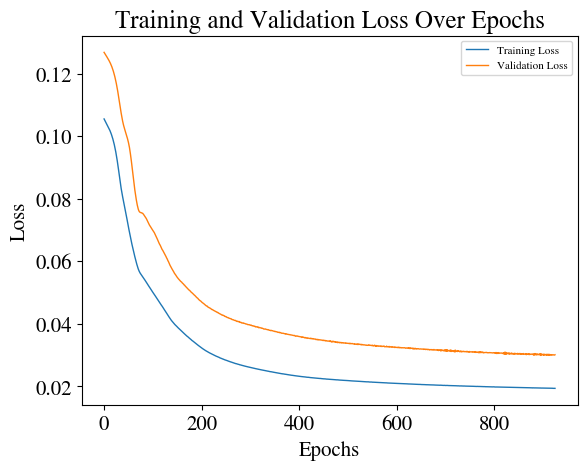

In [31]:
plot_loss(loss_array)

Plot saved as 'modelstats.pdf'


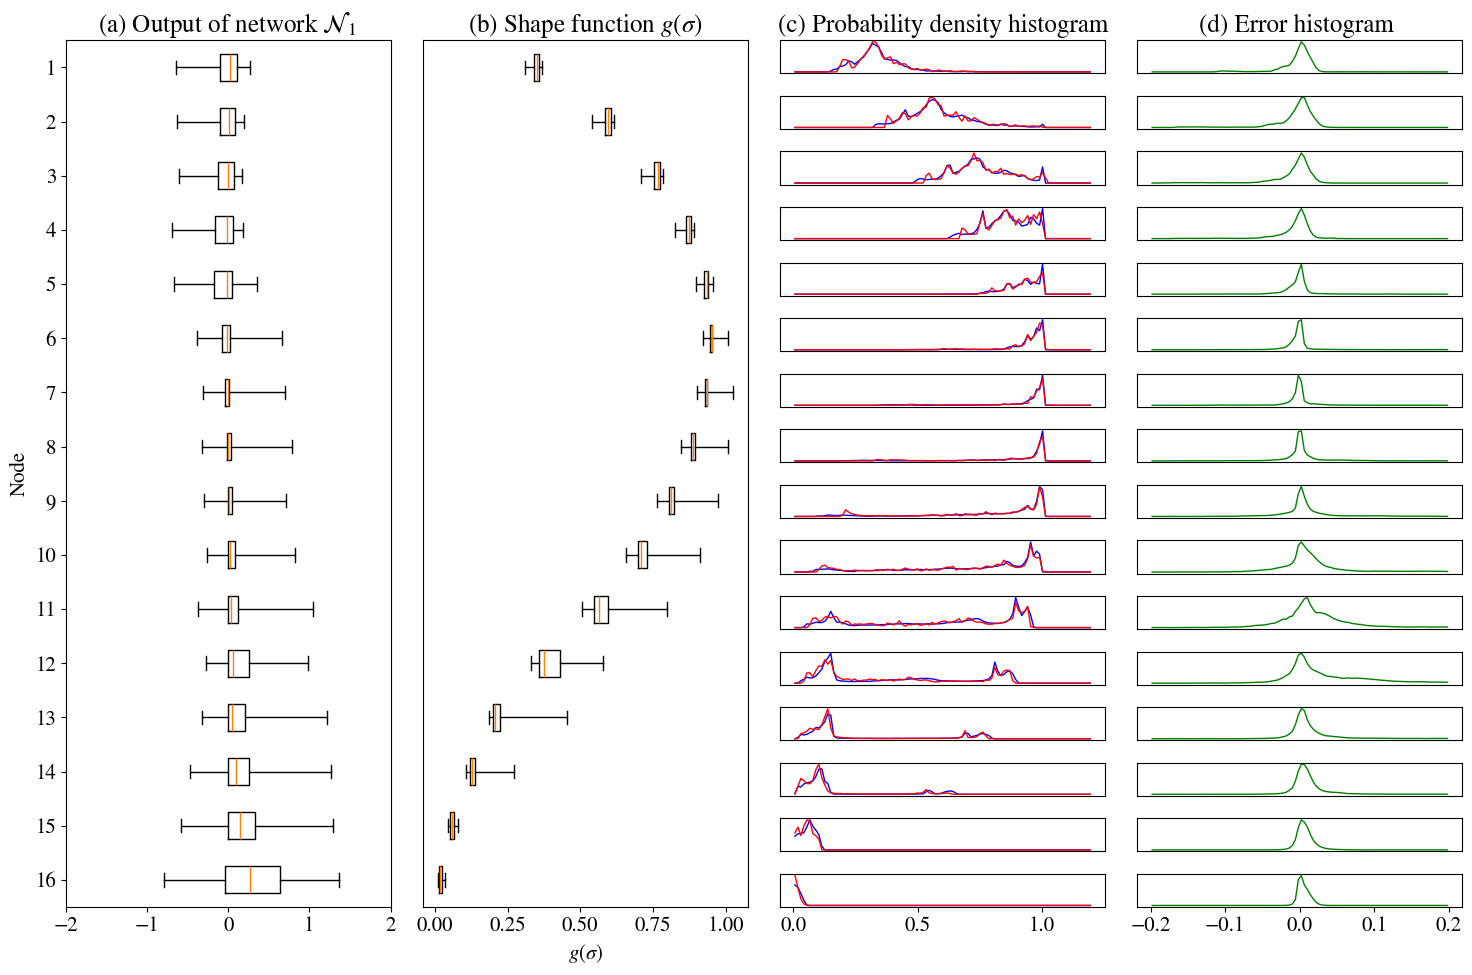

In [32]:
performance_sigma_point(model, x, valid_x, y, valid_y, k_mean, k_std)

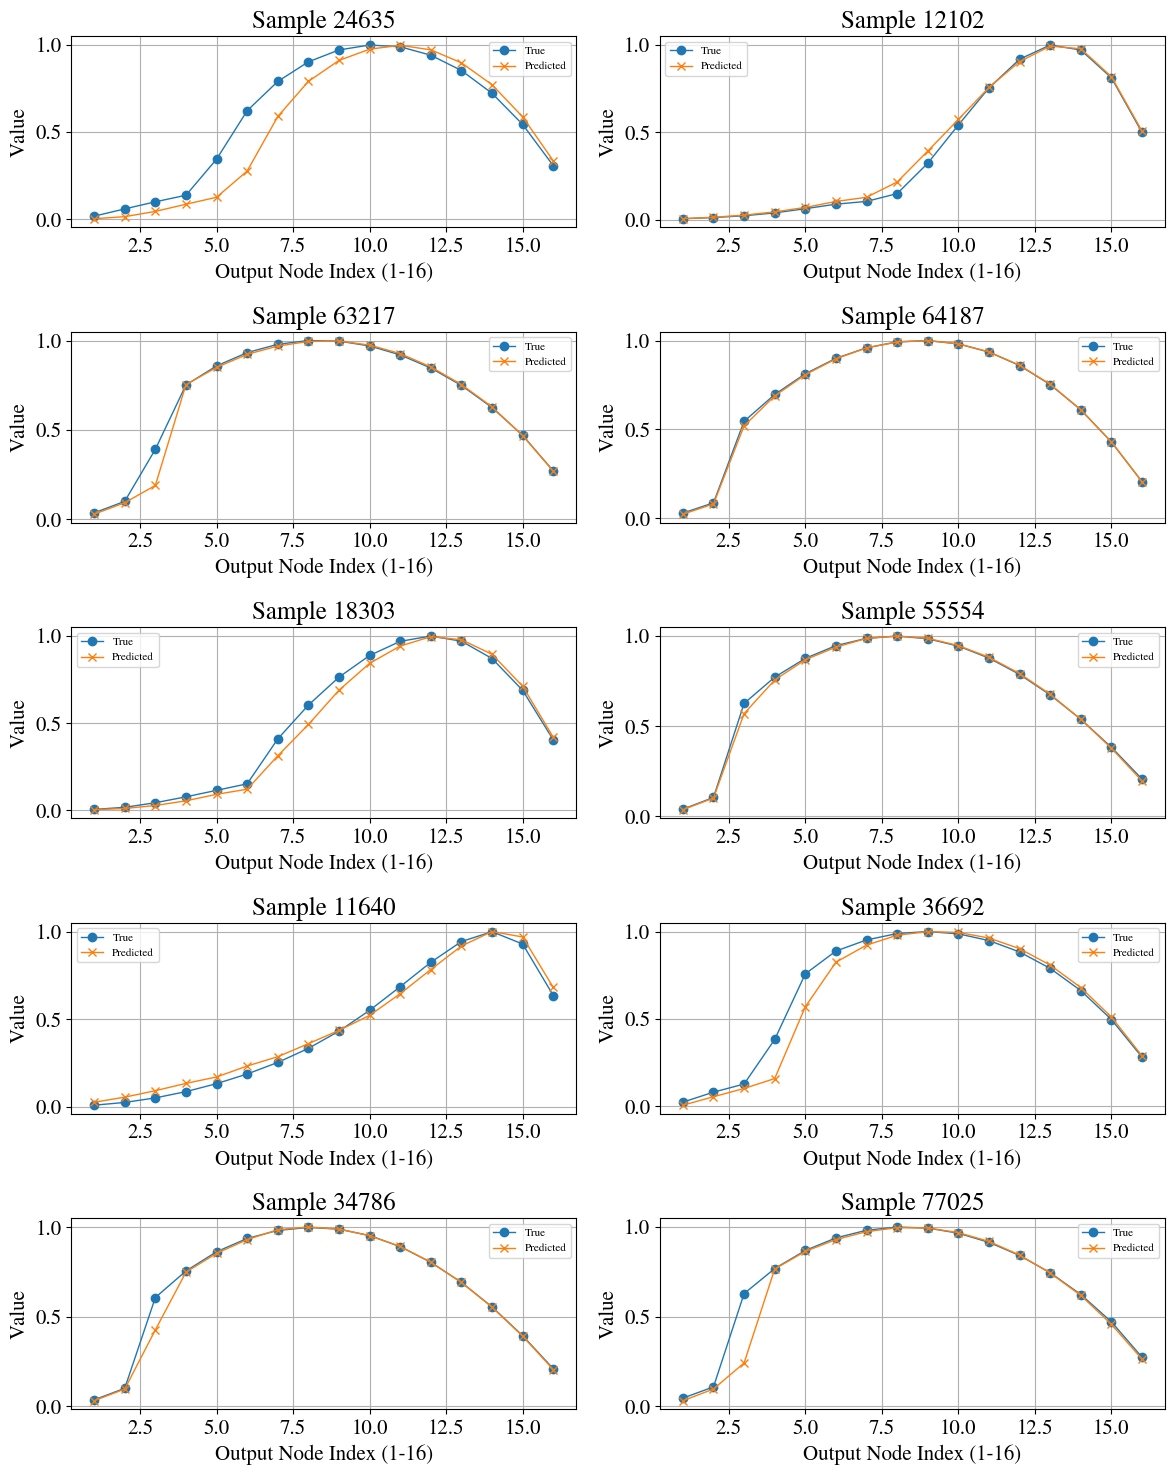

In [33]:
visualize_examples(model, valid_x, valid_y)

# 6. Conclusions

### Strengths

Overall, our final optimized bidirectional LSTM model was much better at predicting the shape function of vertical diffusivity when compared to the vanilla model used by Sane et al. (2023) and in the project 2 starter code. The vanilla model had a validation loss of ~0.05, whereas our final model had a validation loss of <0.03.

Further, for the arbitrary subset of observations, the shape functions predicted by our final model were much closer to the “observed” shape functions produced by the General Ocean Turbulence Model compared to the shape functions predicted by the original model.

Finally, our final model did a much better job at capturing the bimodal distribution of output nodes 11-14, meaning that we accomplished the task that we set out to do in this project.

### Limitations

With that said, our final model is not perfect. Changing the neural network’s architecture from the vanilla model to a Bidirectional LSTM and including the new activation function and weights increased the computation time required to train and validate the model.

If our ultimate goal was to implement the final model into Earth System Models for the purposes of predicting the shape function of vertical diffusivity across the globe over many time steps (as was the goal of Sane et. al), this may not be ideal, as our final model could be too computationally demanding.

However, for scaled-down purposes of predicting shape functions, and for our goal of improving the model’s representation of bimodal output nodes in the shape function, the final model that we developed performed surprisingly well.  